In [ ]:
pip install tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix,
                             PrecisionRecallDisplay)
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.multiclass import OneVsRestClassifier

In [ ]:
# Load the dataset
folder_path = '/content/drive/My Drive/Sem7/ML/ML project/ML dataset'

file_list = os.listdir(folder_path)
print("Files in the folder:", file_list)

file_name = 'Updated_Inclusive_Indian_Online_Scam_Dataset.csv'
file_path = os.path.join(folder_path, file_name)

df = pd.read_csv(file_path)


Files in the folder: ['Updated_Inclusive_Indian_Online_Scam_Dataset.csv']


In [ ]:
# Step 1: EDA (Exploratory Data Analysis)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7953 entries, 0 to 7952
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   transaction_id     7478 non-null   float64
 1   customer_id        7532 non-null   float64
 2   merchant_id        7481 non-null   float64
 3   amount             7261 non-null   float64
 4   transaction_time   7385 non-null   object 
 5   is_fraudulent      7228 non-null   float64
 6   card_type          7386 non-null   object 
 7   location           7430 non-null   object 
 8   purchase_category  7421 non-null   object 
 9   customer_age       7285 non-null   float64
 10  fraud_type         7455 non-null   object 
dtypes: float64(6), object(5)
memory usage: 683.6+ KB
None


In [ ]:
print(df.describe())

       transaction_id    customer_id  merchant_id       amount  is_fraudulent  \
count     7478.000000    7532.000000   7481.00000   7261.00000    7228.000000   
mean       600.858786  542464.492034   2049.66181   6149.98508       0.313365   
std        346.844631  255414.605733     29.08818   3805.09295       0.463893   
min          1.000000  100184.000000   2000.00000     84.71100       0.000000   
25%        296.000000  317669.000000   2025.00000   3031.60500       0.000000   
50%        605.500000  552098.000000   2048.00000   5965.04000       0.000000   
75%        899.750000  763253.000000   2075.00000   8704.22400       1.000000   
max       1200.000000  998799.000000   2099.00000  17960.97600       1.000000   

       customer_age  
count   7285.000000  
mean      43.361153  
std       14.913870  
min       18.000000  
25%       31.000000  
50%       43.000000  
75%       56.000000  
max       69.000000  


<ipython-input-42-9eefdc16f3a5>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_fraudulent', data=df, palette='Set2')


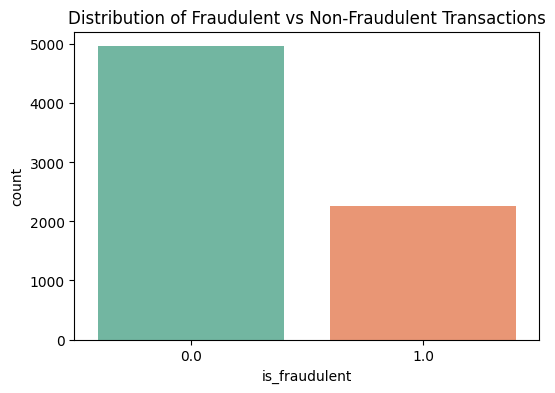

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x='is_fraudulent', data=df, palette='Set2')
plt.title('Distribution of Fraudulent vs Non-Fraudulent Transactions')
plt.show()

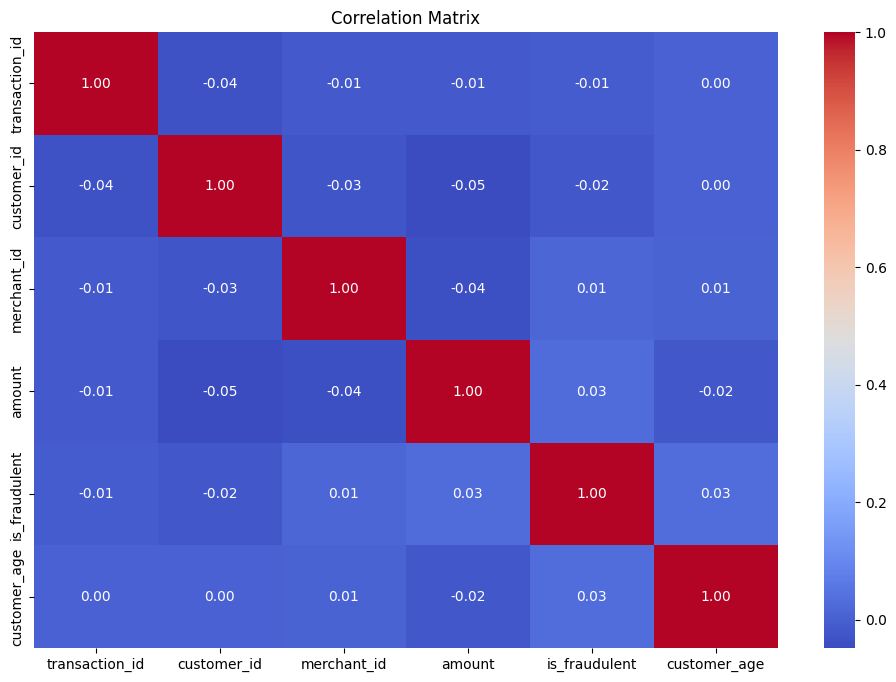

In [ ]:
# Select only the numerical columns from the dataset
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Create a correlation matrix using only numerical columns
plt.figure(figsize=(12,8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

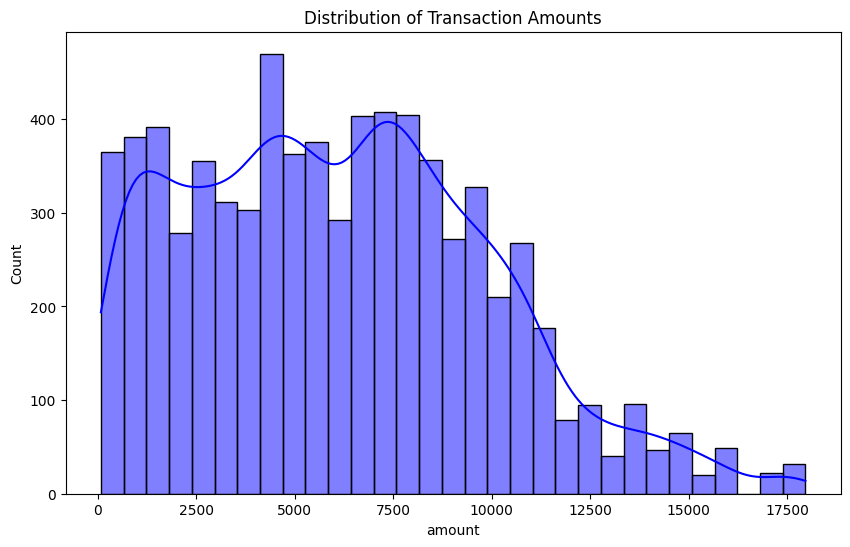

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(df['amount'], kde=True, color='blue')
plt.title('Distribution of Transaction Amounts')
plt.show()

In [ ]:
# Check missing values
missing_values = df.isnull().sum()
print("\nMissing Values in Each Column:\n", missing_values)


Missing Values in Each Column:
 transaction_id       475
customer_id          421
merchant_id          472
amount               692
transaction_time     568
is_fraudulent        725
card_type            567
location             523
purchase_category    532
customer_age         668
fraud_type           498
dtype: int64


In [ ]:
# Step 2: Handle missing values
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
imputer_num = SimpleImputer(strategy='median')
df[num_cols] = imputer_num.fit_transform(df[num_cols])

cat_cols = df.select_dtypes(include=['object']).columns
imputer_cat = SimpleImputer(strategy='most_frequent')
df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

# Drop rows with missing target variable 'is_fraudulent'
df = df.dropna(subset=['is_fraudulent'])

In [ ]:
print("\nMissing values after handling:\n", df.isnull().sum())
print(df.info())


Missing values after handling:
 transaction_id       0
customer_id          0
merchant_id          0
amount               0
transaction_time     0
is_fraudulent        0
card_type            0
location             0
purchase_category    0
customer_age         0
fraud_type           0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7953 entries, 0 to 7952
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   transaction_id     7953 non-null   float64
 1   customer_id        7953 non-null   float64
 2   merchant_id        7953 non-null   float64
 3   amount             7953 non-null   float64
 4   transaction_time   7953 non-null   object 
 5   is_fraudulent      7953 non-null   float64
 6   card_type          7953 non-null   object 
 7   location           7953 non-null   object 
 8   purchase_category  7953 non-null   object 
 9   customer_age       7953 non-null   float64
 10  fraud_type   

In [ ]:
# Step 3: Encode categorical variables
label_enc = LabelEncoder()
df['card_type'] = label_enc.fit_transform(df['card_type'])
df['location'] = label_enc.fit_transform(df['location'])
df['purchase_category'] = label_enc.fit_transform(df['purchase_category'])
df['fraud_type'] = label_enc.fit_transform(df['fraud_type'])

In [ ]:
# Binary classification: Fraudulent (1) vs Non-fraudulent (0)
X = df.drop(columns=['transaction_id', 'customer_id', 'merchant_id', 'transaction_time', 'is_fraudulent'])
y = df['is_fraudulent']  # Binary target

In [ ]:
# Step 4: Prepare features and binary target (is_fraudulent)
X_bin = df.drop(columns=['transaction_id', 'customer_id', 'merchant_id', 'transaction_time', 'is_fraudulent', 'fraud_type'])
y_bin = df['is_fraudulent']  # Binary target

In [ ]:
# Step 5: Split the dataset into training and testing sets for binary classification
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_bin, y_bin, test_size=0.3, random_state=42)

In [ ]:
# Step 6: Normalize numerical features for binary classification
num_cols_bin = X_bin.select_dtypes(include=['float64', 'int64']).columns
scaler_bin = StandardScaler()
X_train_bin[num_cols_bin] = scaler_bin.fit_transform(X_train_bin[num_cols_bin])
X_test_bin[num_cols_bin] = scaler_bin.transform(X_test_bin[num_cols_bin])

<ipython-input-54-09c1af8eefc1>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_bin, palette='Set2')


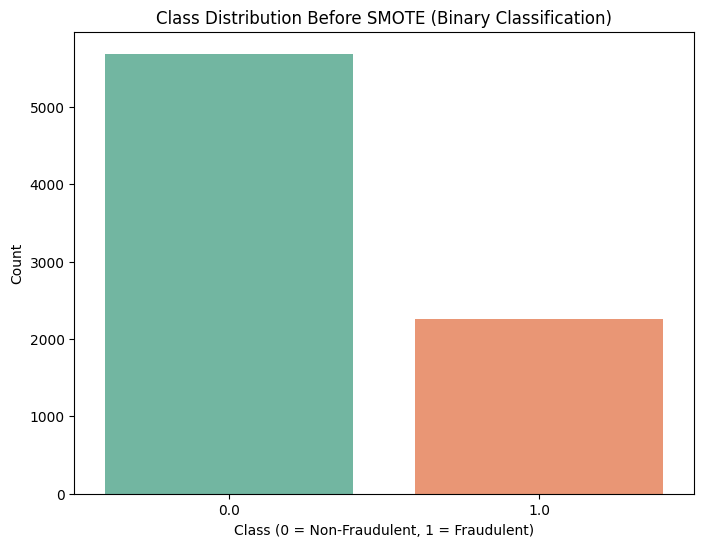

In [ ]:
# Step 5: Visualize class distribution before SMOTE (Binary Classification)
plt.figure(figsize=(8,6))
sns.countplot(x=y_bin, palette='Set2')
plt.title('Class Distribution Before SMOTE (Binary Classification)')
plt.xlabel('Class (0 = Non-Fraudulent, 1 = Fraudulent)')
plt.ylabel('Count')
plt.show()

<ipython-input-55-7ea145f3e8ad>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_bin_smote, palette='Set2')


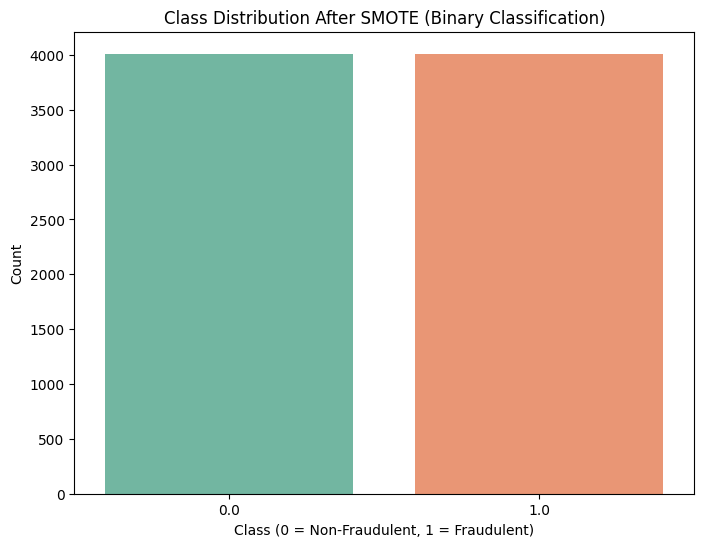

In [ ]:
# Step 8: Apply SMOTE for handling class imbalance in binary classification
smote_bin = SMOTE(random_state=42)
X_train_bin_smote, y_train_bin_smote = smote_bin.fit_resample(X_train_bin, y_train_bin)

# Step 9: Visualize class distribution after SMOTE (Binary Classification)
plt.figure(figsize=(8,6))
sns.countplot(x=y_train_bin_smote, palette='Set2')
plt.title('Class Distribution After SMOTE (Binary Classification)')
plt.xlabel('Class (0 = Non-Fraudulent, 1 = Fraudulent)')
plt.ylabel('Count')
plt.show()

In [ ]:
# Train the Random Forest model for binary classification
model_bin = RandomForestClassifier(max_depth=8, random_state=42)
model_bin.fit(X_train_bin_smote, y_train_bin_smote)

RandomForestClassifier(max_depth=8, random_state=42)

In [ ]:
# Make predictions for the binary classification task
y_pred_bin = model_bin.predict(X_test_bin)

# Step 3: Evaluate performance
accuracy = accuracy_score(y_test_bin, y_pred_bin)
precision = precision_score(y_test_bin, y_pred_bin)
recall = recall_score(y_test_bin, y_pred_bin)
f1 = f1_score(y_test_bin, y_pred_bin)
classification_rep = classification_report(y_test_bin, y_pred_bin)

In [ ]:
# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:\n", classification_rep)

Accuracy: 0.8718
Precision: 0.7379
Recall: 0.8815
F1 Score: 0.8033

Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.87      0.90      1677
         1.0       0.74      0.88      0.80       709

    accuracy                           0.87      2386
   macro avg       0.84      0.87      0.85      2386
weighted avg       0.88      0.87      0.87      2386



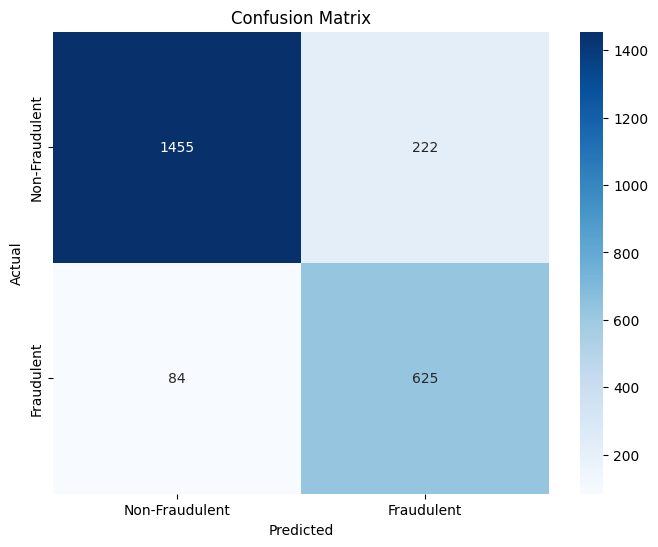

In [ ]:
# Step 4: Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test_bin, y_pred_bin)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fraudulent', 'Fraudulent'],
            yticklabels=['Non-Fraudulent', 'Fraudulent'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

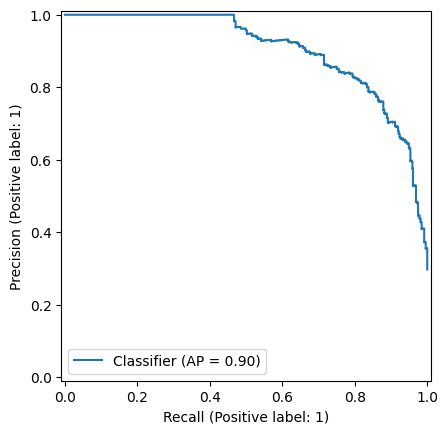

<Figure size 800x600 with 0 Axes>

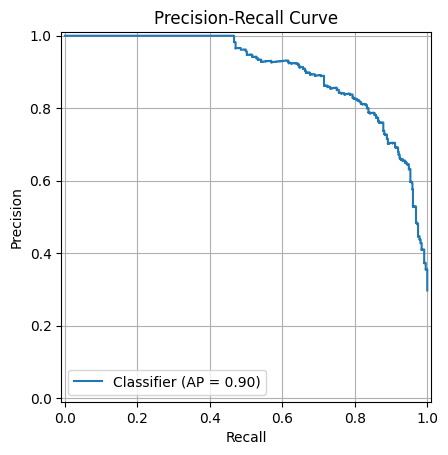

In [ ]:
# Step 5: Precision-Recall Curve Visualization
# Get the predicted probabilities for the positive class
y_pred_proba = model_bin.predict_proba(X_test_bin)[:, 1]

# Create Precision-Recall curve
pr_display = PrecisionRecallDisplay.from_predictions(y_test_bin, y_pred_proba)
plt.figure(figsize=(8, 6))
pr_display.plot()
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()


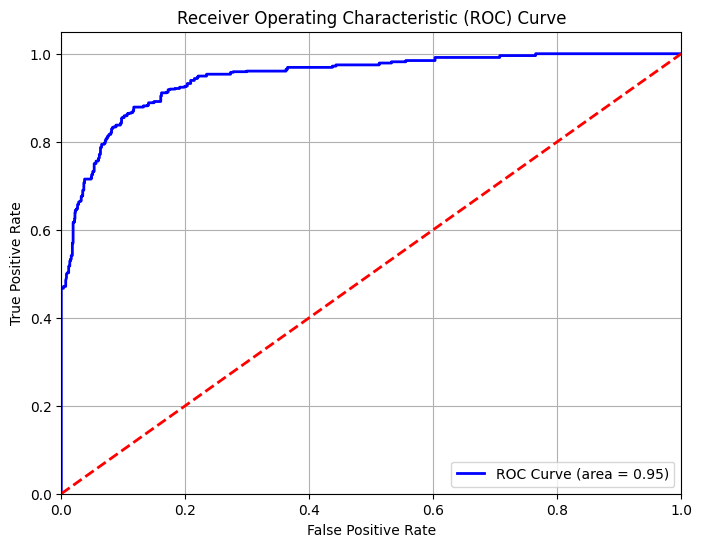

In [ ]:
# ROC Curve Visualization
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

<ipython-input-96-12675482eae1>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')


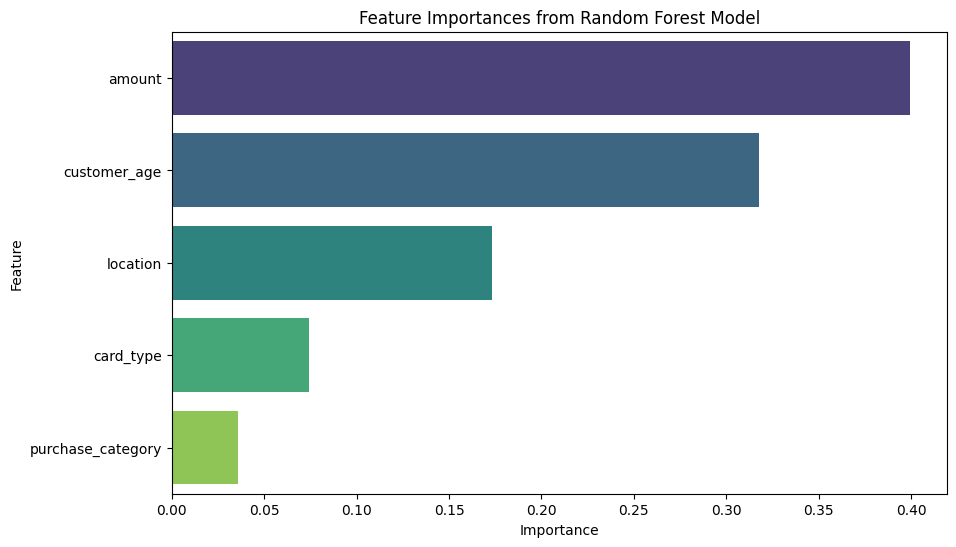

In [ ]:
# Feature Importance Visualization
importances = model_bin.feature_importances_
feature_names = X_train_bin.columns

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
plt.title('Feature Importances from Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
# PART 2: Multi-Class Classification (Fraud Type)

# Mapping fraud types to human-readable labels
fraud_type_labels = {
    0: 'Identity theft',
    1: 'Account takeover',
    2: 'Card-not-present',
    3: 'First-party fraud',
    4: 'Synthetic identity fraud'
}

fraud_type
First-party fraud           2046
Synthetic identity fraud    1496
Card-not-present            1488
Identity theft              1486
Account takeover            1437
Name: count, dtype: int64


<ipython-input-104-95184aabe589>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette='viridis')


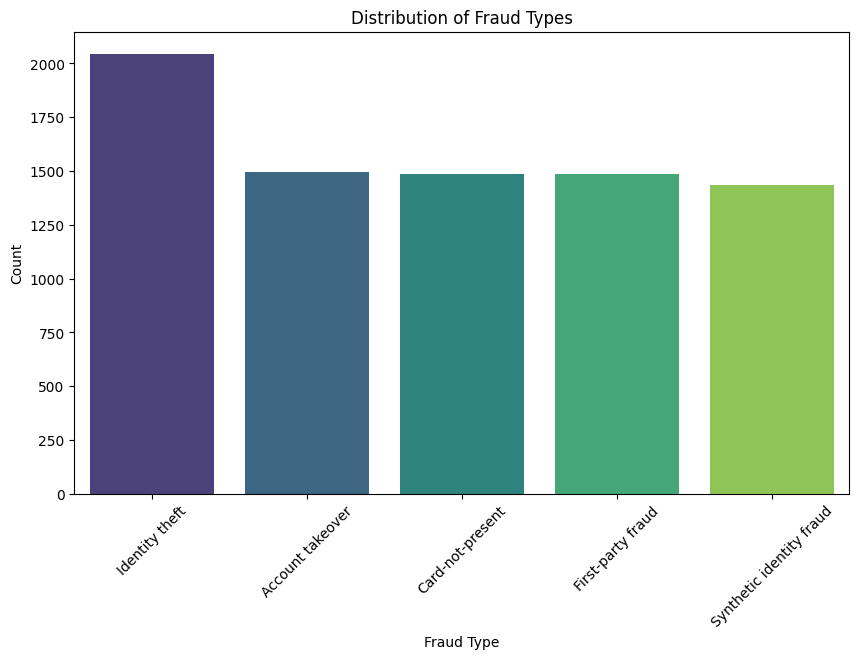

In [ ]:
# Count the occurrences of each fraud type
fraud_counts = df['fraud_type'].value_counts()
print(df['fraud_type'].value_counts())


# Bar Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette='viridis')
plt.title('Distribution of Fraud Types')
plt.xlabel('Fraud Type')
plt.ylabel('Count')
plt.xticks(ticks=fraud_counts.index, labels=list(fraud_type_labels.values()), rotation=45)
plt.show()

In [ ]:
# Replace encoded fraud type values with human-readable labels
df['fraud_type'] = df['fraud_type'].replace(fraud_type_labels)

In [ ]:
# Step 10: Filter only fraudulent transactions for multi-class classification
df_fraud = df[df['is_fraudulent'] == 1]

In [ ]:
# Step 11: Prepare features and multi-class target (fraud_type)
X_multi = df_fraud.drop(columns=['transaction_id', 'customer_id', 'merchant_id', 'transaction_time', 'is_fraudulent', 'fraud_type'])
y_multi = df_fraud['fraud_type']

In [ ]:
# Step 13: Split the dataset into training and testing sets for multi-class classification
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi, y_multi, test_size=0.3, random_state=42, stratify=y_multi)

In [ ]:
# Step 14: Normalize numerical features for multi-class classification
num_cols_multi = X_multi.select_dtypes(include=['float64', 'int64']).columns
scaler_multi = StandardScaler()
X_train_multi[num_cols_multi] = scaler_multi.fit_transform(X_train_multi[num_cols_multi])
X_test_multi[num_cols_multi] = scaler_multi.transform(X_test_multi[num_cols_multi])

In [ ]:
# Train the Random Forest model for multi-class classification
model_multi = RandomForestClassifier(random_state=42,max_depth=8)
model_multi.fit(X_train_multi, y_train_multi)

RandomForestClassifier(max_depth=8, random_state=42)

In [ ]:
# Step 17: Make predictions for multi-class classification
y_pred_multi = model_multi.predict(X_test_multi)

In [ ]:
# Step 18: Evaluate the multi-class classification model
print("Multi-Class Classification Report:")
print(classification_report(y_test_multi, y_pred_multi, target_names=list(fraud_type_labels.values())))

Multi-Class Classification Report:
                          precision    recall  f1-score   support

          Identity theft       0.93      0.91      0.92       117
        Account takeover       0.87      0.87      0.87       144
        Card-not-present       0.91      0.96      0.93       157
       First-party fraud       0.94      0.95      0.95       133
Synthetic identity fraud       0.90      0.86      0.88       129

                accuracy                           0.91       680
               macro avg       0.91      0.91      0.91       680
            weighted avg       0.91      0.91      0.91       680



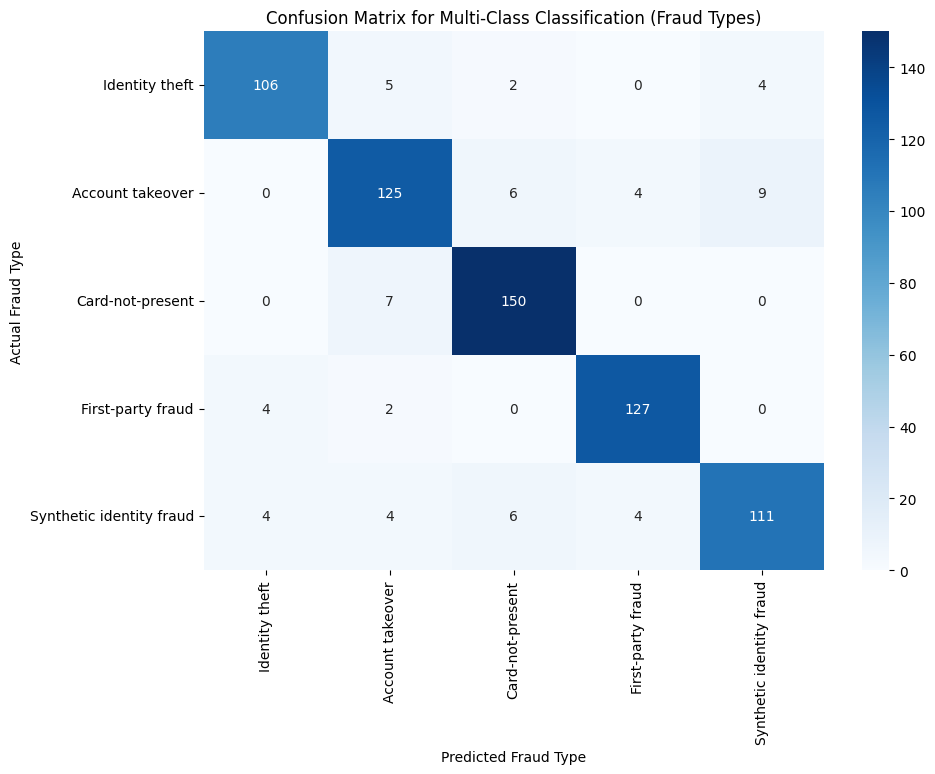

In [ ]:
# Confusion Matrix for Multi-Class Classification
conf_matrix_multi = confusion_matrix(y_test_multi, y_pred_multi)
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix_multi, annot=True, fmt='d', cmap='Blues', xticklabels=list(fraud_type_labels.values()), yticklabels=list(fraud_type_labels.values()))
plt.title('Confusion Matrix for Multi-Class Classification (Fraud Types)')
plt.ylabel('Actual Fraud Type')
plt.xlabel('Predicted Fraud Type')
plt.show()

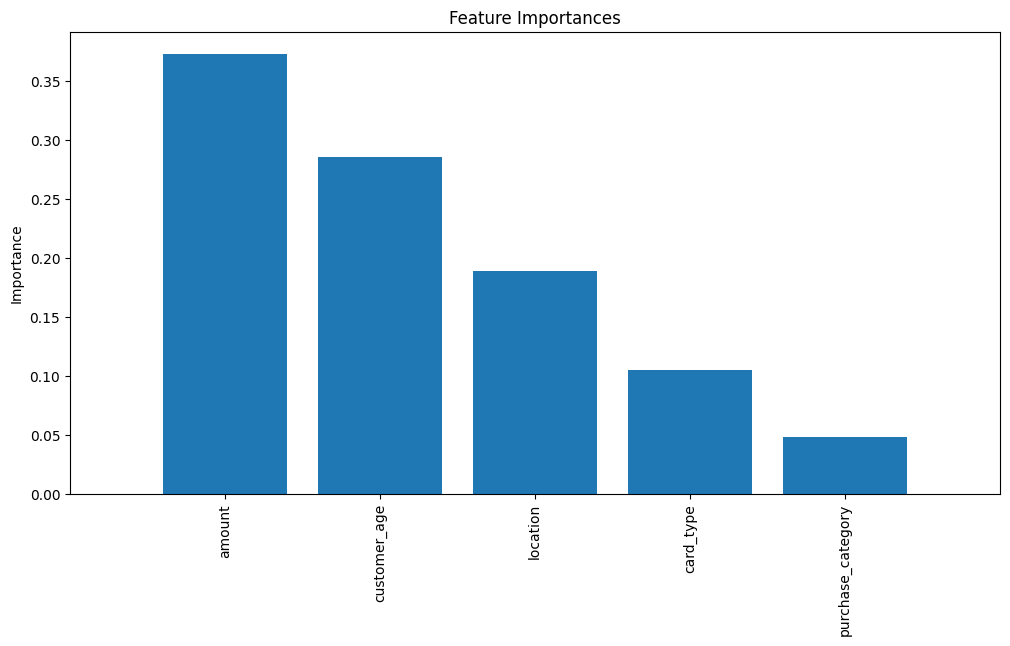

In [ ]:
# Visualization 2: Feature Importance
importances = model_multi.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X_multi.shape[1]), importances[indices], align="center")
plt.xticks(range(X_multi.shape[1]), X_multi.columns[indices], rotation=90)
plt.xlim([-1, X_multi.shape[1]])
plt.ylabel("Importance")
plt.show()